In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",#root is the path where the train/test data is stored
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(#ordered container of modules, data is passed through all the modules in the same order as defined
            nn.Linear(28*28, 512),#applies a linear transformation on the input using its stored weights and biases.
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),#applied after linear transformations to introduce nonlinearity
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # tracks all fields defined inside your model object, and makes all parameters accessible

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310425  [    0/60000]
loss: 2.293182  [ 6400/60000]
loss: 2.276677  [12800/60000]
loss: 2.265479  [19200/60000]
loss: 2.261769  [25600/60000]
loss: 2.220559  [32000/60000]
loss: 2.232788  [38400/60000]
loss: 2.200544  [44800/60000]
loss: 2.192024  [51200/60000]
loss: 2.154835  [57600/60000]
Test Error: 
 Accuracy: 44.4%, Avg loss: 2.157162 

Epoch 2
-------------------------------
loss: 2.174875  [    0/60000]
loss: 2.159164  [ 6400/60000]
loss: 2.100401  [12800/60000]
loss: 2.108453  [19200/60000]
loss: 2.076014  [25600/60000]
loss: 1.999445  [32000/60000]
loss: 2.036534  [38400/60000]
loss: 1.957120  [44800/60000]
loss: 1.957137  [51200/60000]
loss: 1.885809  [57600/60000]
Test Error: 
 Accuracy: 52.7%, Avg loss: 1.888231 

Epoch 3
-------------------------------
loss: 1.928159  [    0/60000]
loss: 1.895784  [ 6400/60000]
loss: 1.772833  [12800/60000]
loss: 1.810281  [19200/60000]
loss: 1.716677  [25600/60000]
loss: 1.653151  [32000/600

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

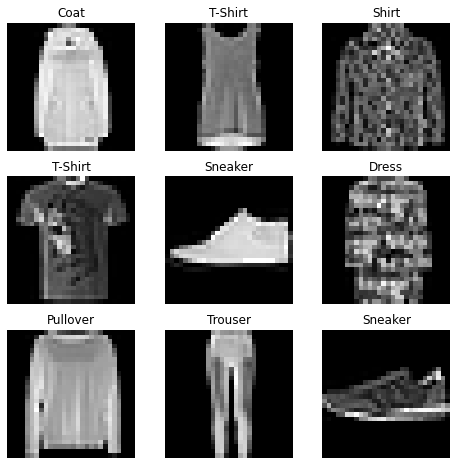

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
import numpy as np

data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
np_array = np.array(data)
x_np = torch.from_numpy(np_array)#creating tensor from numpy

tensor = torch.rand(3,4)
print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

tensor1 = torch.ones(4, 4)
print(f"First row: {tensor1[0]}")
print(f"First column: {tensor1[:, 0]}")
print(f"Last column: {tensor1[..., -1]}")
tensor1[:,1] = 0
print(tensor1)

t1 = torch.cat([tensor1, tensor1, tensor1], dim=1)#concates tensor
print(t1)

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu
First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [ ]:
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)#matrix multipiction, y1,y2,y3 will have same value
#mul instead of matmul for elementwise multiplication

print(f"{tensor1} \n")
tensor1.add_(5)#In-place operations Operations that store the result into the operand are called in-place. They are denoted by a _ suffix
print(tensor1)


In [ ]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()#tensor to numpy
print(f"n: {n}")

n1 = np.ones(5)
t1 = torch.from_numpy(n1)#numpy to tensor

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):#initializes the directory containing the images, the annotations file, and both transforms
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):#__len__ function returns the number of samples in our dataset.
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
#The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s location on disk,
# converts that to a tensor using read_image, retrieves the corresponding label from the csv data in self.img_labels, calls the transform functions on them ,
# and returns the tensor image and corresponding label in a tuple.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


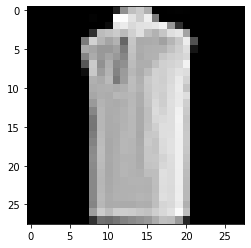

Label: 2


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)#to load mini batches of data 
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),# to convert features img format to normalized tensor format
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))# to convert labels integer format to one hot encoder tensor format
)
#Lambda transforms apply any user-defined lambda function. 

ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

In [ ]:
from torch import nn

softmax = nn.Softmax(dim=1)#. dim parameter indicates the dimension along which the values must sum to 1.
#pred_probab = softmax(logits)#scaled to values [0, 1] representing the model’s predicted probabilities for each class
"""
print(f"Gradient function for loss = {loss.grad_fn}")#calculates gradient funcn for loss
loss.backward()
print(w.grad)
print(b.grad)"""

In [ ]:
"""z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():#to stop gradient tracking
    z = torch.matmul(x, w)+b
print(z.requires_grad)

z = torch.matmul(x, w)+b
z_det = z.detach()#same as torch.no_grad
print(z_det.requires_grad)"""